# Tokenizing the text

In [1]:
import spacy, pandas, networkx, matplotlib.pyplot as plt

In [2]:
from spacy.matcher import Matcher
from operator import itemgetter

In [3]:
from collections import Counter

### Loading model and reading the document


In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
#run for multiple files
inputtext = ""
for i in range(1,20):
    file_name =f"{i}.txt"
    #print(file_name)
    inputtext+=(open(file_name).read())

In [6]:
inputtext
input_doc = nlp(inputtext)

In [42]:
#run for single file
file_name = '15.txt'
input_text = open(file_name).read()
#print(type(input_text))
input_doc = nlp(input_text)

### Sentence Segmentation

In [7]:
sentences = list(input_doc.sents)

In [8]:
sentences

[The Airports Authority of India (AAI) has handed over the Mangaluru airport to the Adani group on lease for a period of 50 years, according to an official statement.,
 The central government in February 2019 had privatised six major airports of the country like Lucknow, Ahmedabad, Jaipur, Mangaluru, Thiruvananthapuram, and Guwahati.,
 After a competitive bidding process, the Adani group won the rights to run all of them.,
 "In accordance to concession agreement executed on February 14, 2020, AAI handed over handling of Mangaluru airport to AdaniOnline on lease for 50 yrs.,
 Exchange of symbolic key held at midnight 00:00 hrs on October 30, 2020," the AAI said on Twitter.,
 The AAI had signed concession agreements with the Adani group on February 14 for operations, management and development of the Mangaluru, Lucknow and Ahmedabad airports.,
 On October 22, the AAI had said in a press release that the Adani group would be taking over the airports at Mangaluru, Lucknow and Ahmedabad by 

### Visualizing dependencies and entities in text

In [10]:
from spacy import displacy

options = {"compact": True,"fine_grained":True, "ents":["EVENT","PERSON","LOC","ORDINAL","CARDINAL","ORG"]}
displacy.render(sentences, style='dep', jupyter=True,options = options)


In [11]:
displacy.render(sentences, style='ent', jupyter=True)

/home/lekha/venv/lib/python3.6/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


### Extracting entities from document

In [12]:
def getEntities(sentence):
    ent1 = ""
    ent2 = ""
    prev_dep = ""
    prev_token = ""
    prefix = ""
    modifier = ""
    
    for tok in nlp(sentence):
        if not tok.is_punct:
            if tok.dep_ == "compound":
                prefix = tok.text
                if prev_dep == "compound":
                    prefix = prev_token + " " + tok.text
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                if prev_dep == "compound":
                    modifier = prev_token + " " + tok.text
                
            #adding subject
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " "+ prefix + " "+tok.text
                #reset everything
                prefix = ""
                modifier = ""
                prev_dep = ""
                prev_token = ""
            
            #adding object
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " "+ tok.text
                
            #updating variables
            prev_dep = tok.dep_
            prev_token = tok.text
            
    return [ent1.strip(), ent2.strip()]

In [30]:
getEntities("I watched a film") #checking if it works fine

['I', 'film']

In [45]:
entity_pairs = []
for s in sentences:
    entity_pairs.append(getEntities(str(s)))

In [46]:
entity_pairs

[['Aegean tsunami', 'internet'],
 ['tidal  waves', 'coastal  areas'],
 ['to Aegean that', 'Turkish  Izmir'],
 ['People', 'there  panic'],
 ['Aegean Izmir', 'Aegean coast'],
 ['Turkish  that', 'surging  Izmir'],
 ['Houses', 'other household it'],
 ['really Ragip Soylu', 'post'],
 ['Search  operations', ''],
 ['700', 'people'],
 ['Reuters', 'two  area'],
 ['authorities', 'highest  damage']]

### Extracting relations

In [47]:
def getRelation(sentence):
    doc = nlp(sentence)
    matcher = Matcher(nlp.vocab)
    
    pattern = [{'DEP':'ROOT'},
              {'DEP':'prep','OP':"?"},
              {'DEP':'agent','OP':"?"},  
              {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1",None, pattern) #match id
    matches = matcher(doc)
    k = len(matches) -1
    span = doc[matches[k][1]:matches[k][2]]
    
    return span.text

In [48]:
getRelation("I watched a film") #checking

'watched'

In [49]:
relations = [getRelation(str(s)) for s in sentences]

In [50]:
relations

['struck',
 'crashed',
 'struck with',
 'ran',
 'is',
 'tweeted',
 'submerged as',
 'said in',
 'are underway',
 'said',
 'reports',
 'said']

In [51]:
print(Counter(relations)) #just to see the most common relations

Counter({'said': 2, 'struck': 1, 'crashed': 1, 'struck with': 1, 'ran': 1, 'is': 1, 'tweeted': 1, 'submerged as': 1, 'said in': 1, 'are underway': 1, 'reports': 1})


# Graph Construction

In [52]:
source = [i[0].lower() for i in entity_pairs]
target = [i[1].lower() for i in entity_pairs]
    
s_graph = pandas.DataFrame({'source' : source, 'target' : target, 'edge': relations})

In [53]:
G=networkx.from_pandas_edgelist(s_graph, "source", "target", 
                          edge_attr=True, create_using=networkx.MultiDiGraph())

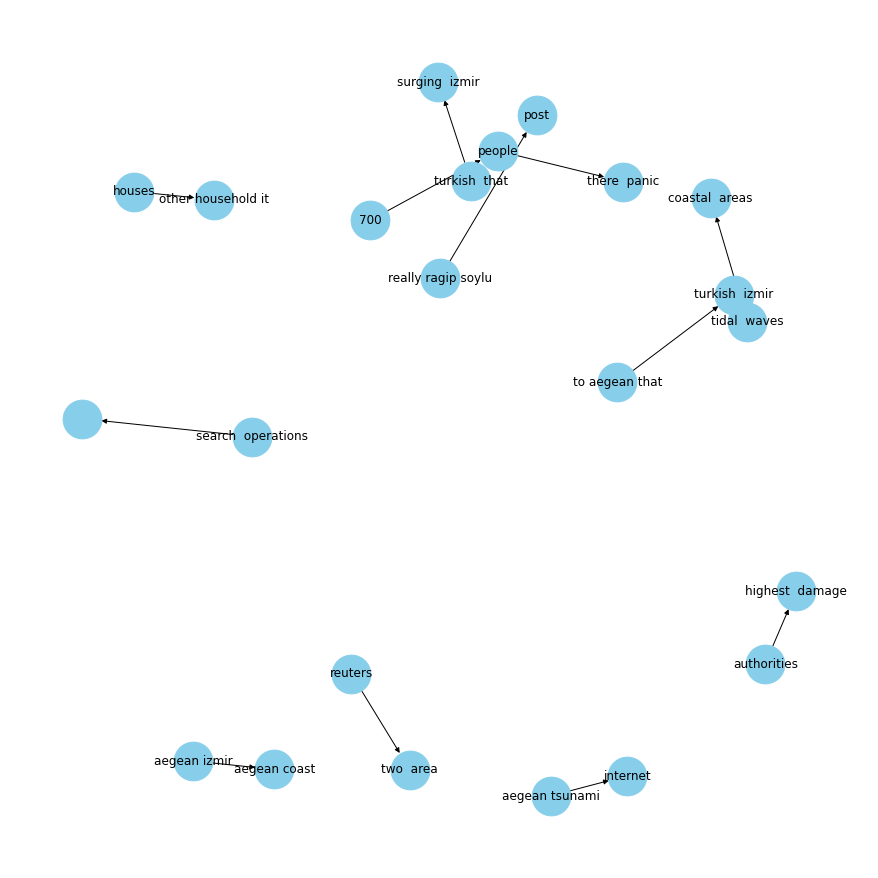

In [54]:
plt.figure(figsize=(12,12))

pos = networkx.spring_layout(G,k=0.5)
networkx.draw(G, with_labels=True, node_color='skyblue', node_size =1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [41]:
G2 = networkx.DiGraph(G)
eigenvector_dict = networkx.eigenvector_centrality(G2,max_iter=1500) # Run eigenvector centrality
networkx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
sorted_deg = sorted(eigenvector_dict.items(),key=itemgetter(1),reverse=True)
for d in sorted_deg:
    print(d)

('social vande saturday', 0.3015103534210975)
('chief minister zoramthanga', 0.3015103534210975)
('song', 0.3015103534210975)
('indian vande performance', 0.3015103534210975)
('social  likes', 0.3015103534210975)
('caption', 0.3015103534210975)
('love', 0.3015103534210975)
('good  diversities', 0.3015103534210975)
('cuteness', 0.3015103534210975)
('vande world', 0.3015103534210975)
('50th  independence', 0.3015103534210975)
('minister narendra modi', 0.000773103470310506)
('soulful vande video', 0.000773103470310506)
('pm modi', 0.000773103470310506)
('esther hnamte', 0.000773103470310506)
('video', 0.000773103470310506)
('brothers  you', 0.000773103470310506)
('india', 0.000773103470310506)
('us', 0.000773103470310506)
('when  you', 0.000773103470310506)
('ar rendition', 0.000773103470310506)
('version', 0.000773103470310506)


In [24]:
degree_dict = dict(G.degree(G.nodes()))
networkx.set_node_attributes(G, degree_dict, 'degree')


In [25]:
sorted_degree = sorted(degree_dict.items(),key=itemgetter(1) ,reverse=True)

In [26]:
for d in sorted_degree:
    print(d)

('he', 10)
('it', 10)
('', 4)
('saturday', 3)
('people', 3)
('scorpio water tank', 3)
('they', 3)
('car', 3)
('vitamin d', 2)
('that', 2)
('video', 2)
('us', 2)
('scorpio', 2)
('she', 2)
('idea', 2)
('officers', 2)
('police', 2)
('facebook page', 2)
('python', 2)
('you', 2)
('joshua walker', 2)
('texas', 2)
('netizens', 2)
('i', 2)
('maha ashtami', 2)
('airports authority', 1)
('official adani statement', 1)
('central  government', 1)
('major  lucknow', 1)
('competitive adani group', 1)
('them', 1)
('2020 concession aai', 1)
('50 mangaluru yrs', 1)
('2020  aai', 1)
('twitter', 1)
('aai', 1)
('mangaluru adani airports', 1)
('adani group', 1)
('october', 1)
('concession agreements', 1)
('three  september', 1)
('china', 1)
('industrial development security', 1)
('plenary  session', 1)
('five year plan', 1)
('domestic exports vision', 1)
('long development xi', 1)
('15  years', 1)
('xi', 1)
('long cpc general tenure', 1)
('5year term which', 1)
('life', 1)
('president', 1)
('greater corona